In [1]:
import nltk
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

np.random.seed(42)
random.seed(42)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Саня\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Загрузка данных

In [2]:
data = pd.read_csv("Tweets.csv")
data.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
data.drop(columns=['textID', 'selected_text'], inplace=True)
data = data.dropna(axis=0).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27480 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


## Разделение на тренировочную и тестовую выборку

In [4]:
y_factorized, uniques = pd.factorize(data['sentiment'], sort=True)
train_data, test_data = train_test_split(data, stratify=y_factorized, random_state=42)
uniques

Index(['negative', 'neutral', 'positive'], dtype='object')

## EDA
### Посмотрим на распределение классов. Присутствует незначительный дисбаланс

<Axes: >

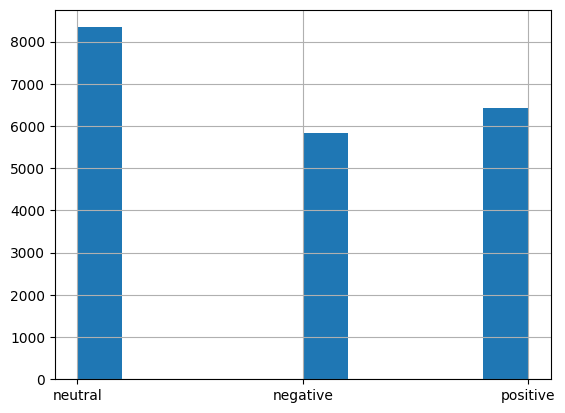

In [5]:
train_data['sentiment'].hist()

### Облако слов

Отобразим распределение самых часто встречающихся слов по классам. Не будем учитывать стоп слова и самые часто встречающиеся слова в датасете (чьё количество превышает 99.5 перцентиль)

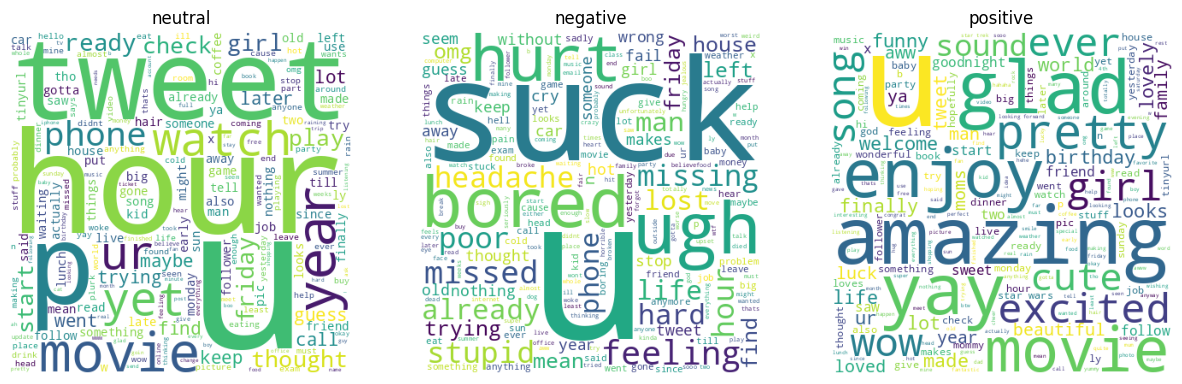

In [6]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

stop_words = stopwords.words('english')

vectorizer = CountVectorizer(stop_words=stop_words)
word_counts = np.asarray(vectorizer.fit_transform(train_data['text']).sum(0)).squeeze()

percentil_99 = np.percentile(word_counts, 99.5)
most_freq_inds = np.nonzero(word_counts > percentil_99)[0]

w2i_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

for ind in most_freq_inds:
    stop_words.append(w2i_vocab[ind])

stop_words = set(stop_words)
classes = train_data['sentiment'].unique()

fig, axes = plt.subplots(1, 3, figsize=(15, 15))
for i, cls in enumerate(classes):
    cls_data = train_data[train_data['sentiment'] == cls]['text']
    cls_str = ' '.join(cls_data.to_list()).lower()
    cloud = WordCloud(stopwords=stop_words, height=400, background_color='white').generate(cls_str)
    axes[i].imshow(cloud)
    axes[i].set_title(cls)
    axes[i].axis("off")
 
plt.show()

Как можно видеть, распределение самых частых слов отличается в зависимости от класса.

### Распределение по длине

Минимальная длина: 1. Максимальная длина: 106


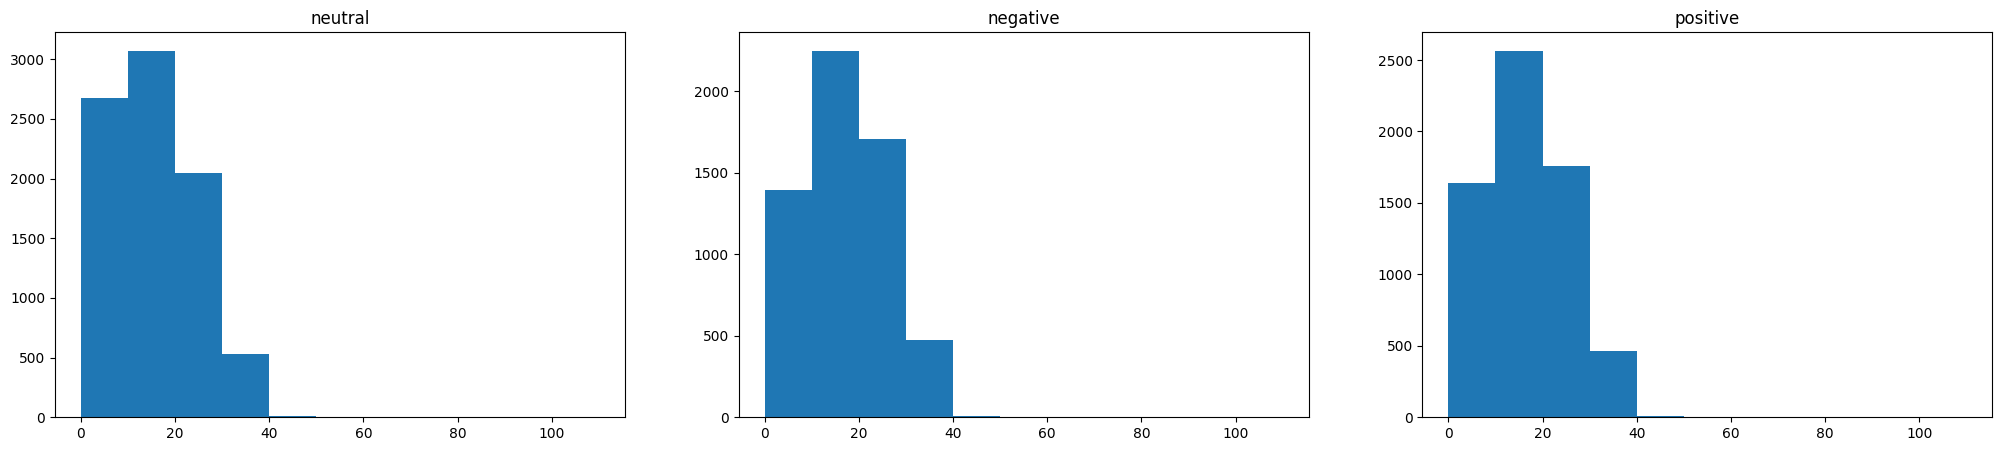

In [7]:
from nltk.tokenize import word_tokenize

text_lens = train_data['text'].apply(word_tokenize).apply(len)

print(f'Минимальная длина: {text_lens.min()}. Максимальная длина: {text_lens.max()}')

fig, axes = plt.subplots(1, 3, figsize=(25, 5))
bins = list(range(0, text_lens.max() + 10, 10))
for i, cls in enumerate(classes):
    cls_lens = text_lens[train_data['sentiment'] == cls]
    axes[i].hist(cls_lens, bins)
    axes[i].set_title(cls)

Распределение по длине почти не отличается между классами. У нейтрального класса больше коротких примеров

##  Подготовка и очистка данных

In [8]:
import re
from nltk.tokenize import word_tokenize
import pymorphy3

def clear_data(df, stopwords):
    morph = pymorphy3.MorphAnalyzer()
    df['text'] = df['text'].apply(lambda text: text.lower())
    df['text'] = df['text'].apply(lambda text: re.sub('[?!@#$1234567890#—ツ►๑۩۞۩•*”˜˜”)*°(°*``,.]', '', text))
    
    df['text'] = df['text'].apply(lambda text: word_tokenize(text))
    df['text'] = df['text'].apply(lambda text: [morph.parse(word)[0].normal_form for word in text if word not in stopwords])
    df['text'] = df['text'].apply(lambda text: ' '.join(text))
    return df

In [9]:
stop_words = stopwords.words('english')
train_data = clear_data(train_data, stop_words)
train_data.head()

,text,sentiment
13544,dm amigui,neutral
2889,got wheres sun =o,neutral
23822,im bored work,negative
22031,cant wait next twitter,positive
22970,tried sleep cant bout call tisha,negative


In [10]:
test_data = clear_data(test_data, stop_words)

## Классические ML алгоритмы
Возьмём 2 классических алгоритма машинного обучения - SVM для задачи классификации, а также RidgeRegression.
В качестве методов векторизации выберем TF-IDF и Word2Vec размерности 300 обученный на Google news

### TF-IDF

In [11]:
def test_model(train_X, train_y, test_X, test_y, model):
    model.fit(train_X, train_y)
    preds = model.predict(test_X)
    print(classification_report(test_y, preds, target_names=uniques))

In [90]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from sklearn.metrics import classification_report, f1_score


vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,1))
train_X = vectorizer.fit_transform(train_data['text'])
train_y = pd.factorize(train_data['sentiment'], sort=True)[0]

test_X = vectorizer.transform(test_data['text'])
test_y = pd.factorize(test_data['sentiment'], sort=True)[0]

print('SVC model:')
classifier = SVC()
test_model(train_X, train_y, test_X, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(train_X, train_y, test_X, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.76      0.56      0.64      1945
     neutral       0.61      0.80      0.69      2779
    positive       0.80      0.67      0.73      2146

    accuracy                           0.69      6870
   macro avg       0.72      0.67      0.69      6870
weighted avg       0.71      0.69      0.69      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.68      0.61      0.65      1945
     neutral       0.62      0.70      0.66      2779
    positive       0.75      0.69      0.72      2146

    accuracy                           0.67      6870
   macro avg       0.68      0.67      0.68      6870
weighted avg       0.68      0.67      0.67      6870



## Word2Vec

In [13]:
import gensim
import gensim.downloader
from gensim.models import KeyedVectors
import tqdm

def docs_to_vectors(data: pd.DataFrame, vectorizer: KeyedVectors):
    text_data = data['text'].map(lambda text: text.split())
    all_vector_representation = []
    for document in tqdm.tqdm(text_data):
        doc_words = [word for word in document if word in vectorizer.key_to_index]
        if doc_words:
            vector_representation = sum([np.array(vectorizer[word]) for word in doc_words])
            vector_representation /= np.linalg.norm(vector_representation, ord=2)
        else:
            vector_representation = np.zeros(300,)
            
        all_vector_representation.append(vector_representation)

    all_vector_representation = np.stack(all_vector_representation, axis=0)
    print(all_vector_representation.shape)

    return all_vector_representation

In [14]:
vector_type = 'word2vec-google-news-300'
vectors_vocab = gensim.downloader.load(vector_type)

In [15]:
vectorized_data_train = docs_to_vectors(train_data, vectors_vocab)
vectorized_data_test = docs_to_vectors(test_data, vectors_vocab)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20610/20610 [00:00<00:00, 37955.89it/s]


(20610, 300)


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6870/6870 [00:00<00:00, 37747.12it/s]


(6870, 300)


In [16]:
print('SVC model:')
classifier = SVC()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

print('RidgeRegression model:')
classifier = RidgeClassifier()
test_model(vectorized_data_train, train_y, vectorized_data_test, test_y, classifier)

SVC model:
              precision    recall  f1-score   support

    negative       0.72      0.65      0.68      1945
     neutral       0.65      0.74      0.69      2779
    positive       0.77      0.70      0.73      2146

    accuracy                           0.70      6870
   macro avg       0.71      0.69      0.70      6870
weighted avg       0.71      0.70      0.70      6870

RidgeRegression model:
              precision    recall  f1-score   support

    negative       0.70      0.64      0.67      1945
     neutral       0.64      0.72      0.68      2779
    positive       0.74      0.69      0.71      2146

    accuracy                           0.69      6870
   macro avg       0.70      0.68      0.69      6870
weighted avg       0.69      0.69      0.69      6870



In [17]:
np.save('w2v_300_train.npy', vectorized_data_train)
np.save('w2v_300_test.npy', vectorized_data_test)

## Нейронные сети
### Попробуем применить 2 архитектуры нейронных сетей, способных работать с последовательностями - сети с одномерными свёртками и LSTM.

In [87]:
import torch
import torch.nn as nn
from torch.optim.adamw import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


class VectorDataset:
    def __init__(self, text_data, y, vectorizer):
        self.text_data = text_data
        self.y = y
        self.vectorizer = vectorizer

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, ind):
        text = self.text_data[ind]
        text = [torch.tensor(self.vectorizer[word]) for word in word_tokenize(text) if word in self.vectorizer.key_to_index]
        if not text:
            return torch.zeros((1, 300)), torch.tensor(self.y[ind])
        return torch.stack(text, axis=0), torch.tensor(self.y[ind])

def data_collator(batch: tuple):
    X = pad_sequence([sample[0] for sample in batch], batch_first=True, padding_side='left')
    y = torch.stack([sample[1] for sample in batch], 0)
    return X, y

def train(model, optimizer, model_name, train_dataloader, val_dataloader, scheduler=None, device='cuda'):
    loss_fn = nn.CrossEntropyLoss()
    best_f1 = 0
    for epoch in range(epochs):
        avg_loss = 0
        avg_f1 = 0
        model.train()
        for train_iter, (X, y) in tqdm.tqdm(enumerate(train_dataloader), desc='Training'):
            X, y = X.to(device), y.to(device)
            logits = model(X)
            loss = loss_fn(logits, y)
            loss.backward()

            optim.step()
            if scheduler is not None:
                scheduler.step()

            optim.zero_grad()

            avg_loss += loss.item()
        model.eval()
        
        all_preds = []
        for val_iter, (X, y) in tqdm.tqdm(enumerate(val_dataloader), desc='Validation'):
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                logits = model(X)
                
            preds = logits.argmax(-1)
            all_preds.append(preds)
            
        all_preds = torch.cat(all_preds)
        f1 = f1_score(test_y, all_preds.cpu().numpy(), average='macro')

        print('Epoch:', epoch + 1, 'Loss:', avg_loss / (train_iter + 1), 'F1:', f1)
        if f1 > best_f1:
            best_f1 = f1
            torch.save(model, f'{model_name}.pth')

### CNN

In [37]:
class MyCNN(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes=3):
        super().__init__()
        layers = []
        for i in range(num_layers):
            layer = nn.Sequential(
                nn.Conv1d(input_dim, hidden_size, 3, padding=1),
                nn.BatchNorm1d(hidden_size),
                nn.ReLU()
            )
            layers.append(layer)
            input_dim = hidden_size
        self.layers = nn.Sequential(*layers)
        self.norm = nn.BatchNorm1d(hidden_size)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = self.norm(self.layers(x.transpose(2, 1)))
        x = x.mean(-1) # global avg pool
        x = self.classifier(x)
        return x

### LSTM

In [94]:
class MyLSTM(nn.Module):
    def __init__(self, input_dim, hidden_size, num_layers, num_classes=3):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_size, 
                            num_layers=num_layers, batch_first=True, 
                            dropout=0.05)
        self.classifier = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.classifier(x[:, -1])
        return x

In [88]:
train_dataset, val_dataset = VectorDataset(train_data['text'].values, train_y, vectors_vocab), VectorDataset(test_data['text'].values, test_y, vectors_vocab)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=data_collator)

In [96]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = MyCNN(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, optim, 'cnn', train_dataloader, val_dataloader, scheduler, device)

Training: 645it [00:07, 86.71it/s]
Validation: 215it [00:01, 124.71it/s]


Epoch: 1 Loss: 0.7608207734518273 F1: 0.7088173377049946


Training: 645it [00:07, 87.64it/s]
Validation: 215it [00:01, 125.07it/s]


Epoch: 2 Loss: 0.6860315253106198 F1: 0.7245600375842024


Training: 645it [00:07, 88.21it/s]
Validation: 215it [00:01, 125.66it/s]


Epoch: 3 Loss: 0.63521007387213 F1: 0.7214895762780039


Training: 645it [00:07, 87.76it/s]
Validation: 215it [00:01, 124.49it/s]


Epoch: 4 Loss: 0.5690465736527776 F1: 0.7202575061839603


Training: 645it [00:07, 86.88it/s]
Validation: 215it [00:01, 125.51it/s]


Epoch: 5 Loss: 0.4768228347911391 F1: 0.7101037777209234


Training: 645it [00:07, 87.85it/s]
Validation: 215it [00:01, 125.07it/s]


Epoch: 6 Loss: 0.3565068269538325 F1: 0.6992071269443908


Training: 645it [00:07, 87.98it/s]
Validation: 215it [00:01, 125.44it/s]


Epoch: 7 Loss: 0.24005881871941478 F1: 0.6906703445746487


Training: 645it [00:07, 88.24it/s]
Validation: 215it [00:01, 126.25it/s]


Epoch: 8 Loss: 0.161131149980911 F1: 0.6798803103972247


Training: 645it [00:07, 88.22it/s]
Validation: 215it [00:01, 126.47it/s]


Epoch: 9 Loss: 0.1165968756458556 F1: 0.682206936865629


Training: 645it [00:07, 88.16it/s]
Validation: 215it [00:01, 126.10it/s]

Epoch: 10 Loss: 0.10303844831624004 F1: 0.6804118967581368


In [95]:
model = MyLSTM(300, 96, 3).to(device)

epochs = 10
optim = AdamW(model.parameters(), lr=2e-3, weight_decay=0.05)

num_steps = len(train_dataloader) * epochs
scheduler = CosineAnnealingLR(optim, num_steps, 1e-7)

train(model, optim, 'cnn', train_dataloader, val_dataloader, scheduler, device)

Training: 645it [00:07, 81.88it/s] 
Validation: 215it [00:01, 125.00it/s]


Epoch: 1 Loss: 0.7610508104165395 F1: 0.723954838644821


Training: 645it [00:07, 87.87it/s]
Validation: 215it [00:01, 135.73it/s]


Epoch: 2 Loss: 0.6565826769022979 F1: 0.7286124822038555


Training: 645it [00:07, 88.48it/s]
Validation: 215it [00:01, 133.04it/s]


Epoch: 3 Loss: 0.6226859196673992 F1: 0.739205744144245


Training: 645it [00:07, 88.56it/s]
Validation: 215it [00:01, 132.72it/s]


Epoch: 4 Loss: 0.5847086022528567 F1: 0.7314446922286858


Training: 645it [00:07, 88.28it/s] 
Validation: 215it [00:01, 138.89it/s]


Epoch: 5 Loss: 0.5425690158855083 F1: 0.732935609007415


Training: 645it [00:07, 90.21it/s]
Validation: 215it [00:01, 136.94it/s]


Epoch: 6 Loss: 0.49827603912630747 F1: 0.7330513133597322


Training: 645it [00:07, 89.35it/s]
Validation: 215it [00:01, 136.94it/s]


Epoch: 7 Loss: 0.4460566586071207 F1: 0.7268200092642613


Training: 645it [00:07, 89.40it/s]
Validation: 215it [00:01, 133.37it/s]


Epoch: 8 Loss: 0.3963555038206337 F1: 0.7234562647835365


Training: 645it [00:07, 88.22it/s]
Validation: 215it [00:01, 135.31it/s]


Epoch: 9 Loss: 0.358336783125419 F1: 0.7227364049760864


Training: 645it [00:07, 89.10it/s]
Validation: 215it [00:01, 133.96it/s]

Epoch: 10 Loss: 0.34156348456361496 F1: 0.7218178022365658
